In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_tsv = pd.read_table('../input/train.tsv',sep='\t')
train_x=df_tsv.drop(['id','click'], axis=1)

train_y = df_tsv['click']
df_tsv_test = pd.read_table('../input/test.tsv',sep='\t')
test_x = df_tsv_test.drop(['id'], axis=1)

train_x_saved = train_x.copy()
test_x_saved = test_x.copy()

# 学習データとテストデータを返す関数
def load_data():
    train_x, test_x = train_x_saved.copy(), test_x_saved.copy()
    return train_x, test_x

# データの読み込み
train_x, test_x = load_data()

C:\Users\miyak\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\miyak\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: read_table is deprecated, use read_csv instead.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
yes=df_tsv[df_tsv.click!=0]

In [3]:
no=df_tsv[df_tsv.click!=1]

In [ ]:
#I4 target encoding
#I5 外れ値指定
#I3 target encoding
#I11～I13 欠損値をxgbで上書き

In [24]:
y_I3=yes['I3']
y_I4=yes['I4']
y_I5=yes['I5']
n_I4=no['I4']
n_I3=no['I3']
n_I5=no['I5']

(array([74215.,     0.,     0.,     0.,     0.,  8303.,     0.,     0.,
            0.,  5229.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

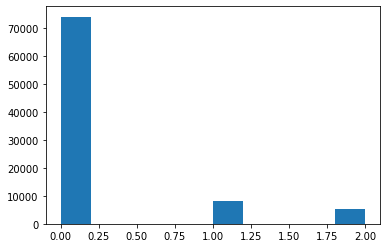

In [28]:
plt.hist(y_I4)

(array([691214.,      0.,      0.,      0.,      0., 251511.,      0.,
             0.,      0., 138570.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

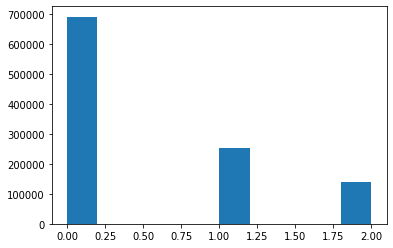

In [27]:
plt.hist(n_I4)

In [37]:
yes_I11_NaN=yes.dropna(subset=['I11'])
no_I11_NaN=no.dropna(subset=['I11'])

In [36]:
yes_I11_NaN.shape

(72800, 22)

In [38]:
no_I11_NaN.shape

(908954, 22)

In [46]:
yes_cnt=yes.shape[0]

In [47]:
no_cnt=no.shape[0]

In [42]:
yes_I14_NaN=yes.dropna(subset=['I14'])
no_I14_NaN=no.dropna(subset=['I14'])

In [48]:
#欠損値割合(クリックあり)
yes_I14_NaN.shape[0]/yes_cnt

0.9865066611963942

In [49]:
#欠損値割合(クリック無し)
no_I14_NaN.shape[0]/no_cnt

0.9644537337174407

In [50]:
import xgboost as xgb
from sklearn.metrics import log_loss

cat_cols=['I3','I4']
train_x, test_x = load_data()
from sklearn.model_selection import KFold

#乱数10固定
kf=KFold(n_splits=4, shuffle=True, random_state=10)

for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
    #学習データからバリデーションデータを分ける
    tr_x, va_x=train_x.iloc[tr_idx].copy(), train_x.iloc[va_idx].copy()
    tr_y, va_y=train_y.iloc[tr_idx], train_y.iloc[va_idx]
    
    for c in cat_cols:
        data_tmp=pd.DataFrame({c: tr_x[c], 'target':tr_y})
        target_mean =data_tmp.groupby(c)['target'].mean()
        #バリデーションデータに平均を代入
        va_x.loc[:, c] = va_x[c].map(target_mean)
        
        tmp=np.repeat(np.nan, tr_x.shape[0])
        kf_encoding=KFold(n_splits=4, shuffle=True, random_state=11)
        for idx_1, idx_2 in kf_encoding.split(tr_x):
            target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
            tmp[idx_2] = tr_x[c].iloc[idx_2].map(target_mean)
        
        tr_x.loc[:, c] = tmp
    
    #xgb学習
    dtrain=xgb.DMatrix(tr_x, label=tr_y)
    dvalid=xgb.DMatrix(va_x, label=va_y)
    params = {'objective': 'binary:logistic', 'silent': 1, 'random_state': 71,
          'eval_metric': 'logloss'}
    num_round = 500
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist,
                  early_stopping_rounds=20)
    va_pred = model.predict(dvalid)
    score = log_loss(va_y, va_pred)
    print(f'logloss: {score:.4f}')

[0]	train-logloss:0.500444	eval-logloss:0.50074
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.395754	eval-logloss:0.396286
[2]	train-logloss:0.332717	eval-logloss:0.333449
[3]	train-logloss:0.292944	eval-logloss:0.293815
[4]	train-logloss:0.267398	eval-logloss:0.268479
[5]	train-logloss:0.250331	eval-logloss:0.251523
[6]	train-logloss:0.238998	eval-logloss:0.240334
[7]	train-logloss:0.231768	eval-logloss:0.233237
[8]	train-logloss:0.225989	eval-logloss:0.227636
[9]	train-logloss:0.22253	eval-logloss:0.22436
[10]	train-logloss:0.220027	eval-logloss:0.222017
[11]	train-logloss:0.217925	eval-logloss:0.220065
[12]	train-logloss:0.216205	eval-logloss:0.218447
[13]	train-logloss:0.215149	eval-logloss:0.217534
[14]	train-logloss:0.214259	eval-logloss:0.216754
[15]	train-logloss:0.213463	eval-logloss:0.216091
[16]	train-logloss:0.212957	eval-logloss:0.215684
[17]	train-log

[161]	train-logloss:0.198071	eval-logloss:0.209664
[162]	train-logloss:0.197997	eval-logloss:0.209657
[163]	train-logloss:0.197911	eval-logloss:0.209642
[164]	train-logloss:0.197826	eval-logloss:0.209661
[165]	train-logloss:0.197744	eval-logloss:0.20963
[166]	train-logloss:0.197675	eval-logloss:0.209611
[167]	train-logloss:0.197624	eval-logloss:0.209618
[168]	train-logloss:0.197574	eval-logloss:0.209605
[169]	train-logloss:0.197506	eval-logloss:0.209593
[170]	train-logloss:0.197447	eval-logloss:0.209594
[171]	train-logloss:0.197371	eval-logloss:0.209587
[172]	train-logloss:0.197319	eval-logloss:0.209579
[173]	train-logloss:0.197245	eval-logloss:0.209583
[174]	train-logloss:0.197168	eval-logloss:0.20958
[175]	train-logloss:0.197134	eval-logloss:0.209584
[176]	train-logloss:0.197096	eval-logloss:0.209568
[177]	train-logloss:0.197044	eval-logloss:0.209554
[178]	train-logloss:0.197033	eval-logloss:0.209554
[179]	train-logloss:0.196966	eval-logloss:0.209573
[180]	train-logloss:0.196913	eval

[87]	train-logloss:0.202565	eval-logloss:0.208619
[88]	train-logloss:0.202494	eval-logloss:0.208626
[89]	train-logloss:0.202443	eval-logloss:0.208634
[90]	train-logloss:0.202394	eval-logloss:0.208634
[91]	train-logloss:0.202297	eval-logloss:0.208603
[92]	train-logloss:0.202149	eval-logloss:0.208565
[93]	train-logloss:0.202091	eval-logloss:0.208573
[94]	train-logloss:0.202008	eval-logloss:0.208572
[95]	train-logloss:0.201956	eval-logloss:0.208579
[96]	train-logloss:0.201878	eval-logloss:0.208587
[97]	train-logloss:0.201797	eval-logloss:0.20859
[98]	train-logloss:0.201766	eval-logloss:0.208582
[99]	train-logloss:0.201688	eval-logloss:0.208603
[100]	train-logloss:0.201578	eval-logloss:0.208582
[101]	train-logloss:0.201526	eval-logloss:0.208588
[102]	train-logloss:0.201503	eval-logloss:0.208585
[103]	train-logloss:0.201389	eval-logloss:0.208521
[104]	train-logloss:0.201331	eval-logloss:0.208518
[105]	train-logloss:0.201246	eval-logloss:0.208522
[106]	train-logloss:0.201143	eval-logloss:0.2

[97]	train-logloss:0.201512	eval-logloss:0.20972
[98]	train-logloss:0.201448	eval-logloss:0.209724
[99]	train-logloss:0.201318	eval-logloss:0.209656
[100]	train-logloss:0.201277	eval-logloss:0.209663
[101]	train-logloss:0.201266	eval-logloss:0.209663
[102]	train-logloss:0.201164	eval-logloss:0.209647
[103]	train-logloss:0.201073	eval-logloss:0.209637
[104]	train-logloss:0.200983	eval-logloss:0.209638
[105]	train-logloss:0.200904	eval-logloss:0.209622
[106]	train-logloss:0.200804	eval-logloss:0.209626
[107]	train-logloss:0.200717	eval-logloss:0.209614
[108]	train-logloss:0.200646	eval-logloss:0.209605
[109]	train-logloss:0.200561	eval-logloss:0.209608
[110]	train-logloss:0.200476	eval-logloss:0.209601
[111]	train-logloss:0.200375	eval-logloss:0.209564
[112]	train-logloss:0.200294	eval-logloss:0.209571
[113]	train-logloss:0.200256	eval-logloss:0.209583
[114]	train-logloss:0.200251	eval-logloss:0.209583
[115]	train-logloss:0.200162	eval-logloss:0.209584
[116]	train-logloss:0.200097	eval-l

[55]	train-logloss:0.205939	eval-logloss:0.207746
[56]	train-logloss:0.205742	eval-logloss:0.207618
[57]	train-logloss:0.205654	eval-logloss:0.207597
[58]	train-logloss:0.205535	eval-logloss:0.207576
[59]	train-logloss:0.205437	eval-logloss:0.207567
[60]	train-logloss:0.205394	eval-logloss:0.207553
[61]	train-logloss:0.205289	eval-logloss:0.20749
[62]	train-logloss:0.205192	eval-logloss:0.207467
[63]	train-logloss:0.205056	eval-logloss:0.207424
[64]	train-logloss:0.205008	eval-logloss:0.207417
[65]	train-logloss:0.204833	eval-logloss:0.207352
[66]	train-logloss:0.204724	eval-logloss:0.207342
[67]	train-logloss:0.204676	eval-logloss:0.20734
[68]	train-logloss:0.204629	eval-logloss:0.207345
[69]	train-logloss:0.204606	eval-logloss:0.207337
[70]	train-logloss:0.204502	eval-logloss:0.207324
[71]	train-logloss:0.20438	eval-logloss:0.207273
[72]	train-logloss:0.204325	eval-logloss:0.207276
[73]	train-logloss:0.204282	eval-logloss:0.207266
[74]	train-logloss:0.204269	eval-logloss:0.207262
[75

In [ ]:
#0.2094,0.28146,0.20939,0.2063
#target encoding 悪くないが良くもない
#xgbとRFはI3,I4のままの方が良い。NNのみtarget encoding

In [229]:
train_x, test_x = load_data()
from sklearn.model_selection import KFold

# 変数をループしてtarget encoding
for c in cat_cols:
    # 学習データ全体で各カテゴリにおけるtargetの平均を計算
    data_tmp = pd.DataFrame({c: train_x[c], 'target': train_y})
    target_mean = data_tmp.groupby(c)['target'].mean()
    # テストデータのカテゴリを置換
    test_x[c] = test_x[c].map(target_mean)

    # 学習データの変換後の値を格納する配列を準備
    tmp = np.repeat(np.nan, train_x.shape[0])

    # 学習データを分割
    kf = KFold(n_splits=4, shuffle=True, random_state=72)
    for idx_1, idx_2 in kf.split(train_x):
        # out-of-foldで各カテゴリにおける目的変数の平均を計算
        target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
        # 変換後の値を一時配列に格納
        tmp[idx_2] = train_x[c].iloc[idx_2].map(target_mean)

    # 変換後のデータで元の変数を置換
    train_x[c] = tmp

(array([8.6488e+04, 5.8800e+02, 2.7300e+02, 1.4200e+02, 3.5000e+01]),
 array([  0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 5 Patch objects>)

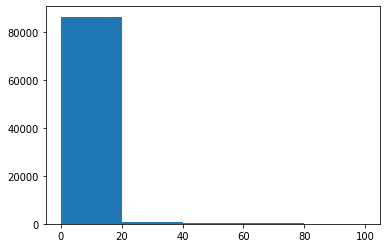

In [60]:
plt.hist(y_I5, bins=5, range=(0,100))

In [94]:
y_I11=yes['I11']
y_I12=yes['I12']
y_I13=yes['I13']
y_I14=yes['I14']
n_I11=no['I11']
n_I12=no['I12']
n_I13=no['I13']
n_I14=no['I14']

In [230]:
cat_cols_C=['C1','C2','C3','C4','C5','C6']
from sklearn.preprocessing import StandardScaler

# 学習データに基づいて複数列の標準化を定義
scaler = StandardScaler()
scaler.fit(train_x[cat_cols_C])

# 変換後のデータで各列を置換
train_x[cat_cols_C] = scaler.transform(train_x[cat_cols_C])
test_x[cat_cols_C] = scaler.transform(test_x[cat_cols_C])

(array([27143.,  9662.,  5778.,  4131.,  2905.,  2323.,  1848.,  1618.,
         1357.,  1362.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 10 Patch objects>)

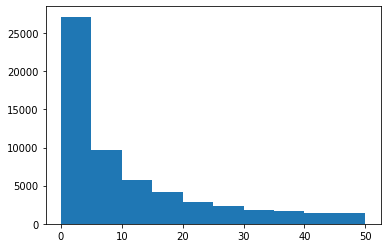

In [174]:
plt.hist(y_I11,range=(0,50))

(array([227863., 100461.,  66021.,  49898.,  37447.,  31120.,  26188.,
         22360.,  18765.,  20070.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 10 Patch objects>)

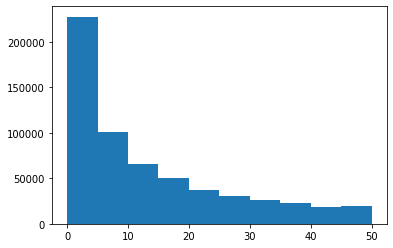

In [173]:
plt.hist(n_I11,range=(0,50))

In [253]:
num_cols=['I11','I12','I13','I14']

(array([899395.,  31917.,  13628.,   8090.,   4854.,   3336.,   2586.,
          1863.,   1537.,   1338.]),
 array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500., 5000.]),
 <a list of 10 Patch objects>)

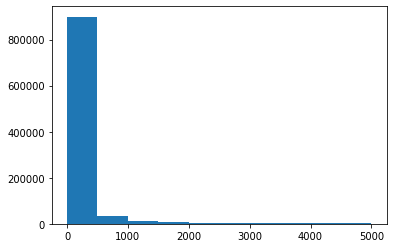

In [278]:
plt.hist(train_x['I11'],range=(0,5000))

In [286]:
train_x["I11"].fillna(train_x.I11.median(), inplace=True)
train_x["I12"].fillna(train_x.I12.median(), inplace=True)
train_x["I13"].fillna(train_x.I13.median(), inplace=True)
train_x["I14"].fillna(train_x.I14.median(), inplace=True)

In [292]:
test_x["I11"].fillna(train_x.I11.median(), inplace=True)
test_x["I12"].fillna(train_x.I12.median(), inplace=True)
test_x["I13"].fillna(train_x.I13.median(), inplace=True)
test_x["I14"].fillna(train_x.I14.median(), inplace=True)

In [293]:
# 学習データに基づいて複数列の標準化を定義
scaler2 = StandardScaler()
scaler2.fit(train_x[num_cols])

# 変換後のデータで各列を置換
train_x[num_cols] = scaler2.transform(train_x[num_cols])
test_x[num_cols] = scaler2.transform(test_x[num_cols])

In [297]:
from models import Model1Xgb, Model1NN, Model2Linear

#stacking
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    kf = KFold(n_splits=4, shuffle=True, random_state=71)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    # 昇順に並べ、インデックスを格納
    order = np.argsort(va_idxes)
    # 元のデータ0,1,2,3....の並び順に予測値を並び替え
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test

Using TensorFlow backend.


In [298]:
model_1b = Model1NN()
pred_train_1b, pred_test_1b = predict_cv(model_1b, train_x, train_y, test_x)

Train on 876781 samples, validate on 292261 samples
Epoch 1/10
876781/876781 [==============================] - 48s 55us/step - loss: 0.2291 - val_loss: 0.2220
Epoch 2/10
876781/876781 [==============================] - 45s 52us/step - loss: 0.2232 - val_loss: 0.2190
Epoch 3/10
876781/876781 [==============================] - 44s 50us/step - loss: 0.2213 - val_loss: 0.2185
Epoch 4/10
876781/876781 [==============================] - 45s 52us/step - loss: 0.2204 - val_loss: 0.2184
Epoch 5/10
876781/876781 [==============================] - 46s 53us/step - loss: 0.2194 - val_loss: 0.2166
Epoch 6/10
876781/876781 [==============================] - 40s 46us/step - loss: 0.2189 - val_loss: 0.2172
Epoch 7/10
876781/876781 [==============================] - 47s 53us/step - loss: 0.2185 - val_loss: 0.2157
Epoch 8/10
876781/876781 [==============================] - 55s 63us/step - loss: 0.2180 - val_loss: 0.2153
Epoch 9/10
876781/876781 [==============================] - 53s 60us/step - loss: 0.

In [299]:
train_x, test_x = load_data()

In [301]:
model_1a = Model1Xgb()
pred_train_1a, pred_test_1a = predict_cv(model_1a, train_x, train_y, test_x)

[0]	train-logloss:0.500598	eval-logloss:0.500473
[1]	train-logloss:0.396005	eval-logloss:0.395786
[2]	train-logloss:0.333066	eval-logloss:0.332774
[3]	train-logloss:0.293227	eval-logloss:0.292919
[4]	train-logloss:0.267313	eval-logloss:0.267041
[5]	train-logloss:0.25026	eval-logloss:0.250061
[6]	train-logloss:0.239222	eval-logloss:0.239115
[7]	train-logloss:0.231704	eval-logloss:0.231621
[8]	train-logloss:0.226635	eval-logloss:0.226595
[9]	train-logloss:0.222689	eval-logloss:0.222669
[0]	train-logloss:0.500403	eval-logloss:0.500925
[1]	train-logloss:0.395564	eval-logloss:0.396407
[2]	train-logloss:0.332691	eval-logloss:0.333794
[3]	train-logloss:0.292698	eval-logloss:0.294089
[4]	train-logloss:0.267267	eval-logloss:0.268831
[5]	train-logloss:0.250353	eval-logloss:0.252142
[6]	train-logloss:0.238991	eval-logloss:0.240886
[7]	train-logloss:0.231351	eval-logloss:0.233411
[8]	train-logloss:0.226331	eval-logloss:0.22847
[9]	train-logloss:0.222302	eval-logloss:0.224515
[0]	train-logloss:0.50

In [302]:
#xgb
print(f'logloss: {log_loss(train_y, pred_train_1a, eps=1e-7):.4f}')
#nn
print(f'logloss: {log_loss(train_y, pred_train_1b, eps=1e-7):.4f}')

logloss: 0.2234
logloss: 0.2163


In [303]:
train_x_2 = pd.DataFrame({'pred_1a': pred_train_1a, 'pred_1b': pred_train_1b})
test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a, 'pred_1b': pred_test_1b})

In [305]:
train_x_2.head()

,pred_1a,pred_1b
0,0.203645,0.285235
1,0.097898,0.106969
2,0.042639,0.020729
3,0.116502,0.119637
4,0.144528,0.150928


In [306]:
model_2 = Model2Linear()
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, train_y, test_x_2)
# pred_train_2トレーニングデータのvalの予測値
print(f'logloss: {log_loss(train_y, pred_train_2, eps=1e-7):.4f}')

logloss: 0.2228


In [307]:
pred_test_2

array([0.09087201, 0.05178191, 0.05947241, ..., 0.0669737 , 0.03461151,
       0.04775942])

In [310]:
df_csv = pd.read_csv('sample_submit.csv',header=None)

In [321]:
#提出用DataFrame作成
df=df_csv.drop([1],axis=1)
df_num=df.values
df_num_1=df_num.flatten()
df_result=pd.DataFrame({0:df_num_1,1:pred_test_2})

In [343]:
#csvファイル書き出し
df_result.to_csv("sample_submit.csv",index=False,header=False)

In [336]:
#最終スコア0.206
#21位/82位
df_csv.head()

,0,1
0,1169042,0.335178
1,1169043,0.688459
2,1169044,0.768471
3,1169045,0.251175
4,1169046,0.464559
